# Milestone 4

#### Importing data

In [4]:
import pandas as pd

data = pd.df = pd.read_csv("C:/Users/torig/Project_2/Customer_loans_in_finance/cleaned_dataframe.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   member_id                   44139 non-null  int64  
 1   loan_amount                 44139 non-null  int64  
 2   term                        44139 non-null  object 
 3   int_rate                    44139 non-null  float64
 4   instalment                  44139 non-null  float64
 5   grade                       44139 non-null  object 
 6   sub_grade                   44139 non-null  object 
 7   employment_length           44139 non-null  object 
 8   home_ownership              44139 non-null  object 
 9   annual_inc                  44139 non-null  float64
 10  verification_status         44139 non-null  object 
 11  issue_date                  44139 non-null  object 
 12  loan_status                 44139 non-null  object 
 13  payment_plan                441

## Task 1 - Current State of Loan:

Total recovered = Total recovered principal + total rececovered interest
Percentage recovered = Total recovered / Total Payment * 100 [dividing the recovered amount by the total payments gives the recovery rate.]

Amount paid in 6 months = Installment * 6 [Calculate amount to be paid in 6 months - assuming a consistent monthly installment this is the amount that will be paid in the next 6 months for each]

Total Percentage of Loans Recovered: 95.43%
Total Amount to be Paid Back in 6 Months: £98,715,852.36


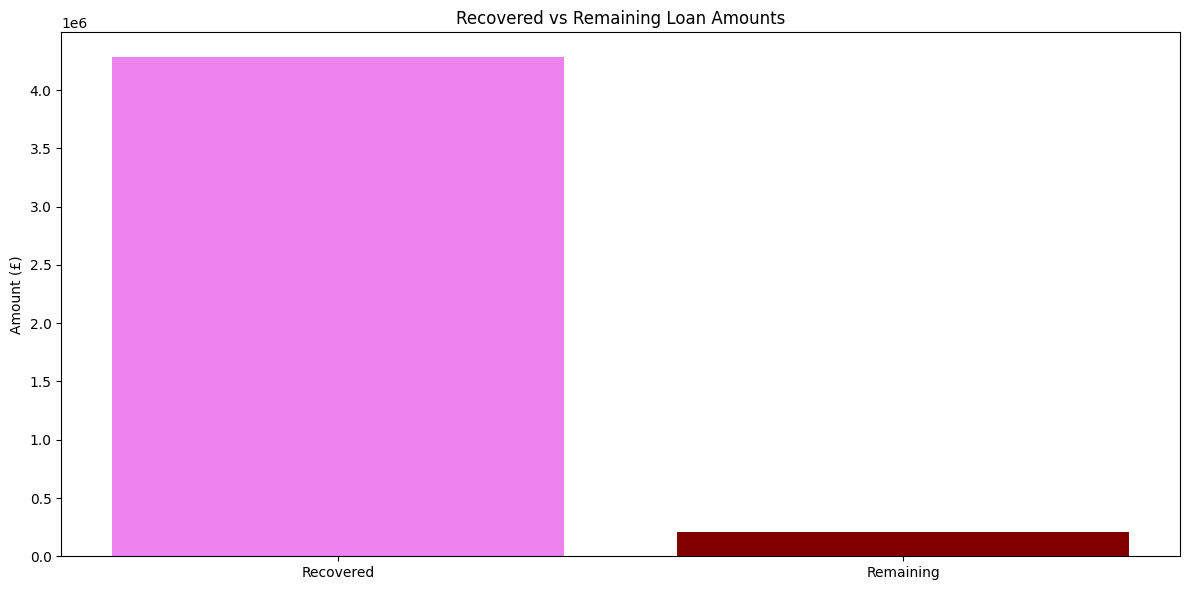

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

data['total_recovered'] = data['total_rec_prncp'] + data['total_rec_int']
data['percentage_recovered'] = (data['total_recovered'] / data['total_payment']) * 100

total_percentage_recovered = (data['total_recovered'].sum() / data['total_payment'].sum()) * 100

print(f"Total Percentage of Loans Recovered: {total_percentage_recovered:.2f}%")


# Visualization
plt.figure(figsize=(12, 6))

# Bar chart: Recovered vs Remaining
recovered = data['total_recovered'].sum()
remaining = data['total_payment'].sum() - recovered
plt.bar(['Recovered', 'Remaining'], [recovered, remaining], color=['violet', 'maroon'])
plt.title('Recovered vs Remaining Loan Amounts')
plt.ylabel('Amount (£)')


plt.tight_layout()
plt.show()


Total Amount to be Paid Back in 6 Months: £98,715,852.36


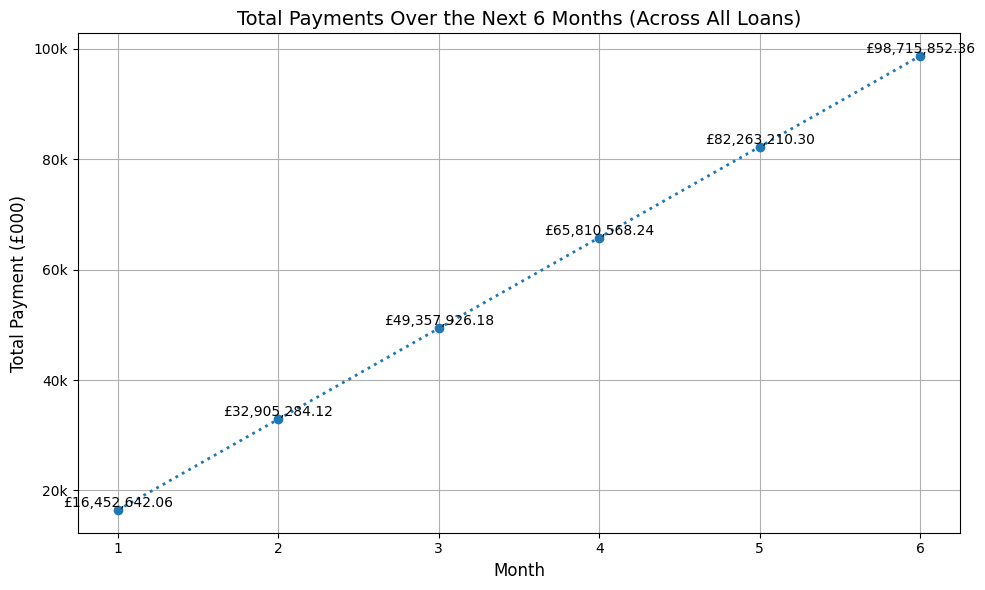

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

data['amount_paid_6_months'] = data['instalment'] * 6
total_amount_in_6_months = data['instalment'].sum() * 6
print(f"Total Amount to be Paid Back in 6 Months: £{total_amount_in_6_months:,.2f}")

# Now, we create the total payment for each month (1 to 6) across all loans
months = np.array([1, 2, 3, 4, 5, 6])

# Calculate the total payments per month (same for each month since the payment is fixed)
total_payments_per_month = data['instalment'].sum() * months

# Create a custom formatter to display monetary values (GBP)
formatter = FuncFormatter(lambda x, _: f'{int(x/1000000):,}k')

# Plotting the total payments over the next 6 months
plt.figure(figsize=(10, 6))
plt.plot(months, total_payments_per_month,marker = 'o' ,linestyle=':', linewidth=2)

for i, value in enumerate(total_payments_per_month):
    plt.text(months[i], value, f'£{value:,.2f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.title('Total Payments Over the Next 6 Months (Across All Loans)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Payment (£000)', fontsize=12)
plt.xticks(months)  # Ensure all months 1-6 are shown as tick marks

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)

# Display the grid
plt.grid(True)

plt.tight_layout()
plt.show()


### Task 2 - Calculating loss

In [77]:

charged_off_loans = data[data['loan_status'] == 'Charged Off']

total_loans = len(data)
charged_off_count = len(charged_off_loans)
percentage_charged_off = (charged_off_count / total_loans) * 100

total_paid_on_charged_off_loans = charged_off_loans['total_rec_prncp'].sum() + charged_off_loans['total_rec_int'].sum()

# Print results
print(f"Percentage of Charged Off Loans: {percentage_charged_off:.2f}%\n")
print(f"Total Amount Paid on Charged Off Loans: £{total_paid_on_charged_off_loans:,.2f}")


Percentage of Charged Off Loans: 9.77%

Total Amount Paid on Charged Off Loans: £269,858.67


### Task 3 - Calculating Projected loss

For each 'Charged Off' loan I will need to calc the potential rev the company would have generate if the loan had completed its term.

Term is given in months either 36 or 60. The remaining months will be :

> remaining_months = term - months_paid

> months_paid is from total_rec_prncp / instalment

To find the loss for each 'Charged Off' loan I will need to multiply the instalment by the remaining months.

In [108]:
# Ensure you're working on a copy of the DataFrame or use .loc to avoid the warning
charged_off_loans = charged_off_loans.copy()
charged_off_loans['months_paid'] = ((pd.to_datetime(charged_off_loans['last_payment_date']) - pd.to_datetime(charged_off_loans['issue_date'])).dt.days) // 30

charged_off_loans['remaining_months'] = charged_off_loans.apply(
    lambda row: 36 - row['months_paid'] if row['term'] == '36 months'
    else 60 - row['months_paid'] if row['term'] == '60 months' else np.nan, axis=1)


print(charged_off_loans[['months_paid', 'remaining_months']].head())

     months_paid  remaining_months
6              7                29
45             7                53
71             6                30
92             1                35
109            3                33


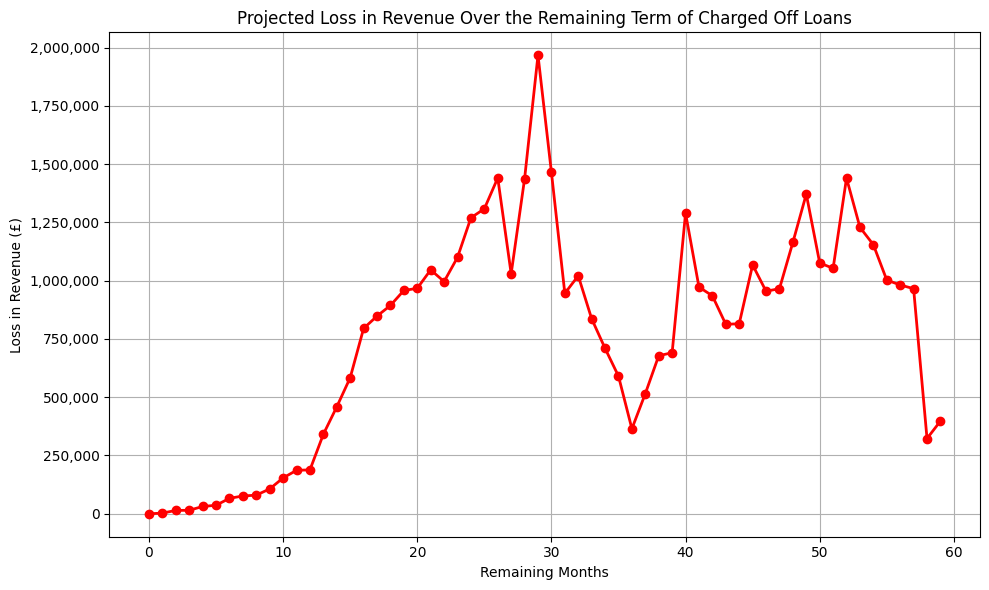

Total Projected Loss in Revenue: £46,162,340.94


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


charged_off_loans['expected_revenue'] = charged_off_loans['instalment'] * charged_off_loans['remaining_months']

charged_off_loans['loss_in_revenue'] = charged_off_loans['expected_revenue'] - charged_off_loans['total_rec_prncp']

charged_off_loans = charged_off_loans[charged_off_loans['remaining_months'] >= 0]

# Group by remaining_months and sum the losses
loss_by_month = charged_off_loans.groupby('remaining_months')['loss_in_revenue'].sum()

# Plot the loss over the remaining months
plt.figure(figsize=(10, 6))
plt.plot(loss_by_month.index, loss_by_month.values, marker='o', color='r', linestyle='-', linewidth=2)

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')

plt.title('Projected Loss in Revenue Over the Remaining Term of Charged Off Loans')
plt.xlabel('Remaining Months')
plt.ylabel('Loss in Revenue (£)')

plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Show summary stats
print(f"Total Projected Loss in Revenue: £{charged_off_loans['loss_in_revenue'].sum():,.2f}")



### Task 4 - Possible loss:

In [118]:
print(data['loan_status'].unique())

['Current' 'Fully Paid' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)' 'Default'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


In [128]:
behind_status = ['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period']

behind_on_payments = data[data['loan_status'].isin(behind_status)].copy()

# Calculate the percentage of customers behind on payments
total_customers = len(data)
customers_behind = len(behind_on_payments)
percentage_behind = (customers_behind / total_customers) * 100

# Print the percentage of customers behind on payments
print(f"Percentage of customers behind on payments: {percentage_behind:.2f}%")




Percentage of customers behind on payments: 1.76%


In [129]:
# Calculate 'months_paid' if not already available
if 'months_paid' not in behind_on_payments.columns:
    behind_on_payments.loc[:, 'months_paid'] = (behind_on_payments['total_rec_prncp'] / behind_on_payments['instalment']).round().astype(int)

# Calculate remaining months for behind_on_payments customers
behind_on_payments.loc[:, 'remaining_months'] = behind_on_payments.apply(
    lambda row: 36 - row['months_paid'] if row['term'] == 36 else 60 - row['months_paid'], axis=1)

# Now calculate expected revenue for these customers (monthly installment * remaining months)
behind_on_payments.loc[:, 'expected_revenue'] = behind_on_payments['instalment'] * behind_on_payments['remaining_months']

# Calculate the loss in revenue for these customers
behind_on_payments.loc[:, 'loss_in_revenue'] = behind_on_payments['expected_revenue'] - behind_on_payments['total_rec_prncp']

# Sum the loss in revenue
total_loss_in_revenue = behind_on_payments['loss_in_revenue'].sum()

# Print results
print(f"Percentage of customers behind on payments: {len(behind_on_payments) / len(data) * 100:.2f}%")
print(f"Total potential loss in revenue if these customers were charged off: £{total_loss_in_revenue:,.2f}")


Percentage of customers behind on payments: 1.76%
Total potential loss in revenue if these customers were charged off: £18,952,867.70


In [130]:
# Calculate projected loss if customers finish the full term
behind_on_payments['projected_loss'] = (
    behind_on_payments['instalment'] * behind_on_payments['remaining_months']
) - behind_on_payments['total_rec_prncp']

# Sum of the projected losses for all customers in behind_on_payments
total_projected_loss = behind_on_payments['projected_loss'].sum()
print(f"Total Projected Loss: £{total_projected_loss:,.2f}")


Total Projected Loss: £18,952,867.70


In [131]:
# Filter customers that are either late or have defaulted
late_and_defaulted_customers = behind_on_payments[
    (behind_on_payments['loan_status'] == 'Late (31-120 days)') | 
    (behind_on_payments['loan_status'] == 'Default')
]

# Calculate total expected revenue for all customers
total_expected_revenue = behind_on_payments['instalment'].sum() * behind_on_payments['remaining_months'].sum()

# Calculate expected revenue from late and defaulted customers
total_expected_revenue_late_default = late_and_defaulted_customers['instalment'].sum() * late_and_defaulted_customers['remaining_months'].sum()

# Calculate percentage of total expected revenue from these customers
percentage_revenue_late_default = (total_expected_revenue_late_default / total_expected_revenue) * 100

print(f"Percentage of Total Expected Revenue from Late and Defaulted Customers: {percentage_revenue_late_default:.2f}%")


Percentage of Total Expected Revenue from Late and Defaulted Customers: 38.42%


### Task 5 - Indicators of loss:

We will be comparing 'Charged Off' loans and 'Currently late' or in 'default' therefore could be charged off! 

Things that may be useful:
- grade: Might indicate the loan's risk level.
- purpose: Different loan purposes might affect the likelihood of repayment.
- home_ownership: Owning a home may be a sign of financial stability.
- employment_length: Longer employment might indicate more financial stability.
- dti: Debt-to-income ratio could reveal whether the borrower is financially overburdened.
- annual_inc: Annual income could also correlate with the ability to repay loans.
- delinq_2yrs: Recent delinquencies might indicate future repayment difficulties.
- open_accounts: More open accounts could correlate with higher risk of non-payment.

**Using countplot to see:**
if riskier grades are more likely to be charged off // identify whether specific loan purposes have a higher likelihood of non-repayment // analyse whether home ownership affects the likelihood of loan repayment // analyze whether recent delinquencies increase the likelihood of a loan being charged off or going late/default 

**Using boxplot to see:**
if high DTI correlates with late/default loans or charged-off loans // helping assess whether low-income individuals are more likely to default // to compare the number of open accounts for different loan statuses.

In [159]:
# Create a subset of these users:

# Filter the customers that are either Charged Off / Late (31-120 days) or Default
charged_off_customers = data[data['loan_status'] == 'Charged Off']
late_default_customers = data[
    (data['loan_status'] == 'Late (31-120 days)') | 
    (data['loan_status'] == 'Default')
]

# Combine the two groups for analysis
at_risk_customers = pd.concat([charged_off_customers, late_default_customers])


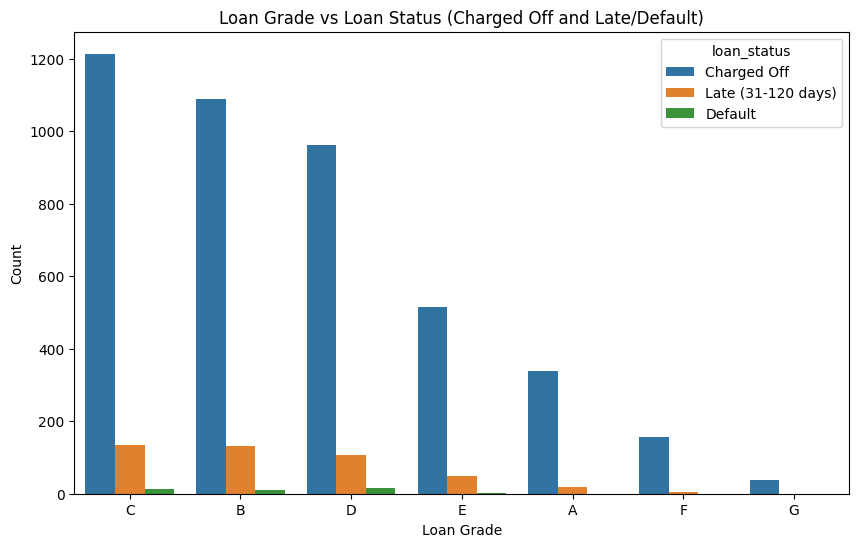

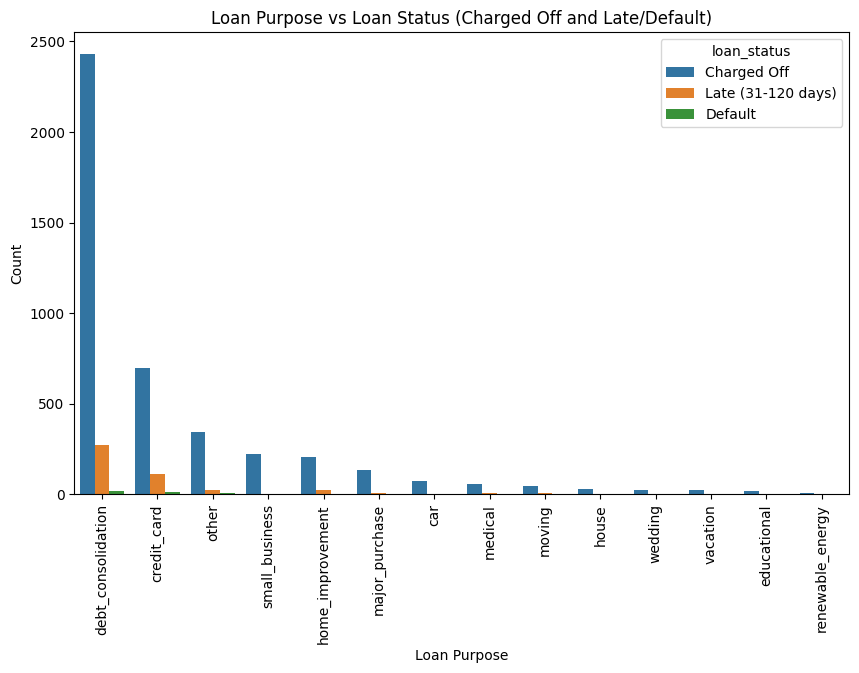

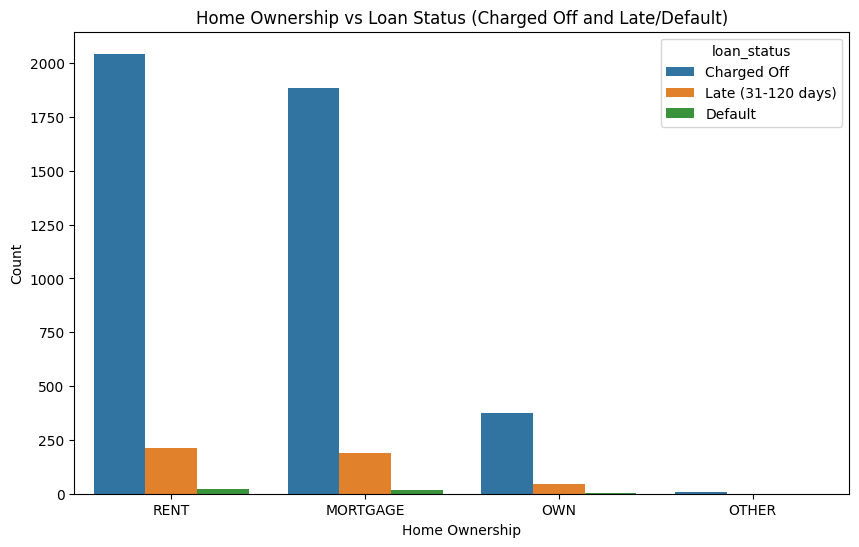

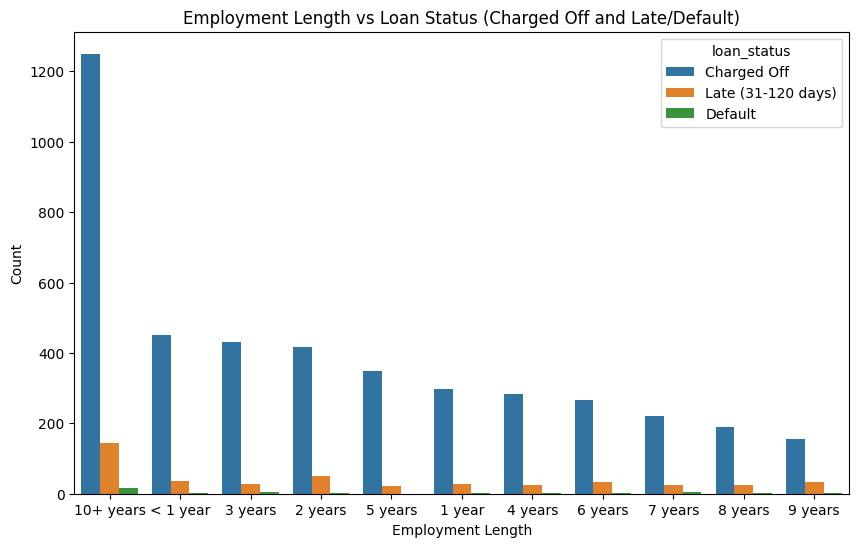

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

grade_order = at_risk_customers.groupby('grade')['loan_status'].apply(lambda x: (x == 'Charged Off').sum()).sort_values(ascending=False).index
purpose_order = at_risk_customers.groupby('purpose')['loan_status'].apply(lambda x: (x == 'Charged Off').sum()).sort_values(ascending=False).index
home_ownership_order = at_risk_customers.groupby('home_ownership')['loan_status'].apply(lambda x: (x == 'Charged Off').sum()).sort_values(ascending=False).index
emp_order = at_risk_customers.groupby('employment_length')['loan_status'].apply(lambda x: (x == 'Charged Off').sum()).sort_values(ascending=False).index

# Visualizing loan grade distribution for at-risk customers
plt.figure(figsize=(10, 6))
sns.countplot(data=at_risk_customers, x='grade', hue='loan_status', order = grade_order)
plt.title('Loan Grade vs Loan Status (Charged Off and Late/Default)')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.show()

# Visualizing loan purpose distribution for at-risk customers
plt.figure(figsize=(10, 6))
sns.countplot(data=at_risk_customers, x='purpose', hue='loan_status', order=purpose_order)
plt.title('Loan Purpose vs Loan Status (Charged Off and Late/Default)')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Visualizing home ownership vs loan status
plt.figure(figsize=(10, 6))
sns.countplot(data=at_risk_customers, x='home_ownership', hue='loan_status', order=home_ownership_order)
plt.title('Home Ownership vs Loan Status (Charged Off and Late/Default)')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()

# Visualizing home ownership vs loan status
plt.figure(figsize=(10, 6))
sns.countplot(data=at_risk_customers, x='employment_length', hue='loan_status', order=emp_order )
plt.title('Employment Length vs Loan Status (Charged Off and Late/Default)')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.show()



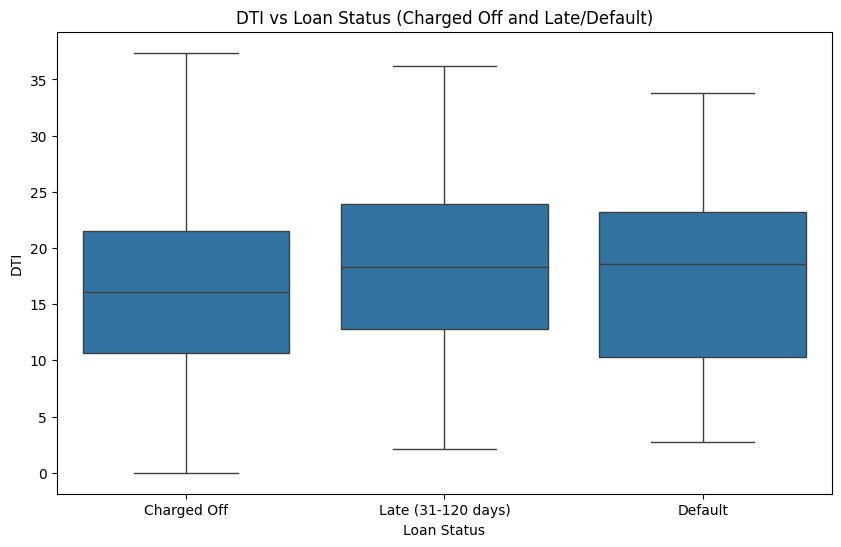

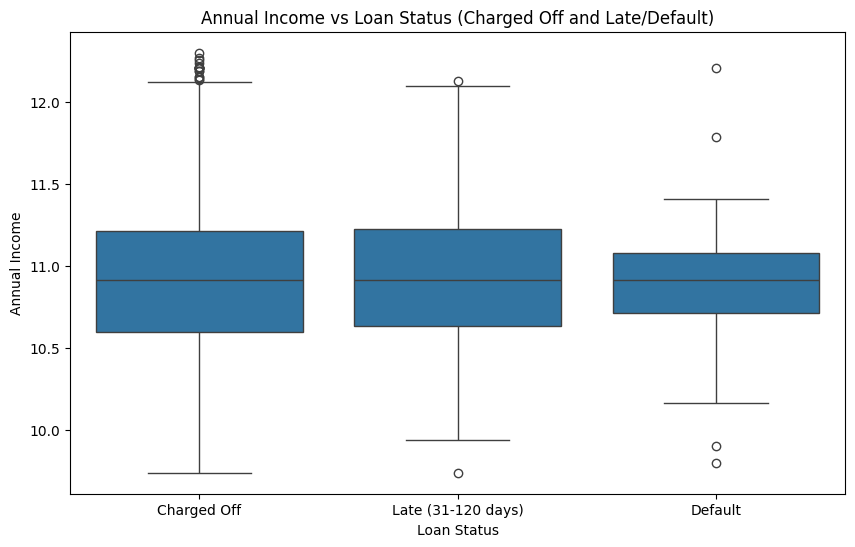

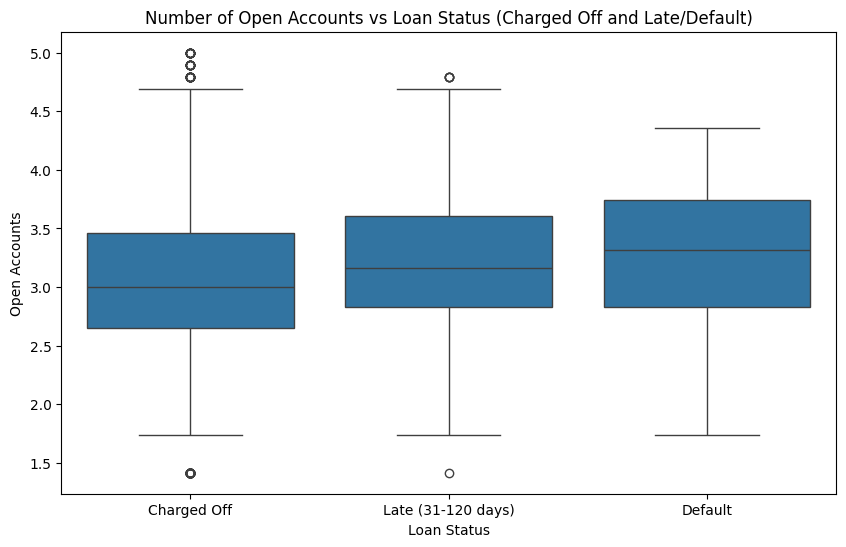

In [163]:
# Visualizing DTI (Debt to Income ratio) for at-risk customers
plt.figure(figsize=(10, 6))
sns.boxplot(data=at_risk_customers, x='loan_status', y='dti')
plt.title('DTI vs Loan Status (Charged Off and Late/Default)')
plt.xlabel('Loan Status')
plt.ylabel('DTI')
plt.show()

# Visualizing Annual Income for at-risk customers
plt.figure(figsize=(10, 6))
sns.boxplot(data=at_risk_customers, x='loan_status', y='annual_inc')
plt.title('Annual Income vs Loan Status (Charged Off and Late/Default)')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')
plt.show()

# Visualizing the number of open accounts for at-risk customers
plt.figure(figsize=(10, 6))
sns.boxplot(data=at_risk_customers, x='loan_status', y='open_accounts')
plt.title('Number of Open Accounts vs Loan Status (Charged Off and Late/Default)')
plt.xlabel('Loan Status')
plt.ylabel('Open Accounts')
plt.show()